# Quién es quién en los precios 

Este cuaderno de python busca proporcionar el código necesario para responder a ciertas preguntas de interés usando la base de datos que ya hemos limpiado en los pasos anteriores. Los datos se encuentran en S3 y todo se corre en spark. Se adjuntan las imágenes de los resultados obtenidos al correr el código en el cluster de EMR. 

#### Creando la sesión de spark

In [19]:
from pyspark.sql.window import Window
from pyspark.sql.functions import year, col, row_number, collect_set, max as max_, min as min_, lit, countDistinct, lag, size
from pyspark.sql.types import StringType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
spark = SparkSession.builder.getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
spark

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Cargando el CSV a Spark directo de S3

In [7]:
df = spark.read.option("delimiter", "|").csv("s3://itam-analytics-erwin/quien_es_quien/quien_es_quien.csv", header=True, inferSchema=True)
df.select(df.columns[0], df.columns[1], df.columns[2], df.columns[3], df.columns[4]).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------------+--------------------+------------------+
|            producto|        presentacion|           marca|           categoria|          catalogo|
+--------------------+--------------------+----------------+--------------------+------------------+
|             a.s.cor|frasco gotero 24 ...|             s/m|        medicamentos|      medicamentos|
|              aceite|botella 1 lt. veg...|           1-2-3|aceites y grasas ...|           basicos|
|              aceite|botella 850 ml. v...|             ave|aceites y grasas ...|             pacic|
|              aceite|botella 946 ml. c...|          canoil|aceites y grasas ...|           basicos|
|              aceite|botella 840 ml. c...|         capullo|aceites y grasas ...|           basicos|
|              aceite|botella 900 ml. v...|  gran tradicion|aceites y grasas ...|           basicos|
|              aceite|botella 765 ml. maiz|          mazola|aceites y grasas ...|          

### Guardar el CSV como parquet en S3, particionalo por catalogo

In [8]:
df.write.parquet("s3://itam-analytics-erwin/partition_qeq/", mode="overwrite", partitionBy=["catalogo"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Carga el parquet en Spark

In [9]:
df_data = spark.read.parquet("s3://itam-analytics-erwin/partition_qeq/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Contesta las siguientes preguntas utilizando PySpark. Realiza el siguiente análisis (por año) y sobre todos los catálogos.

### ¿Cuántos catálogos diferentes tenemos?

In [10]:
# Pasamos la columna fecharegistro a fecha y extraemos el año
df = df.withColumn("fecharegistro", col("fecharegistro").cast("date"))
df = df.withColumn("anio", year("fecharegistro"))

# Agrupamos por año y contar
df.groupBy("anio").agg(f.countDistinct("catalogo").alias("catalogos")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+---------+
|anio|catalogos|
+----+---------+
|2018|       10|
|2019|       11|
|2020|       10|
|2021|       10|
|2022|       11|
|2023|       11|
|2024|       10|
+----+---------+

### ¿Cuáles son los 20 catálogos con más observaciones?

In [14]:
# Agrupamos por año y por catálogo, y hacemos un count
df_grouped = df.groupBy("anio", "catalogo").agg(f.count("catalogo").alias("observaciones"))

# Ordenamos los registros por el conteo de observaciones de manera descendente y obtenemos los top 20
df_result = df_grouped.orderBy(col("observaciones").desc()).limit(20)
df_result.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------------------+-------------+
|anio|          catalogo|observaciones|
+----+------------------+-------------+
|2018|           basicos|      8804761|
|2022|           basicos|      7945110|
|2023|           basicos|      7742108|
|2019|           basicos|      7398860|
|2021|           basicos|      6919490|
|2020|           basicos|      6170515|
|2018|      medicamentos|      3657969|
|2023|      medicamentos|      3192617|
|2022|      medicamentos|      3177815|
|2021|      medicamentos|      2937404|
|2019|      medicamentos|      2887105|
|2020|      medicamentos|      2571915|
|2024|           basicos|      1986577|
|2018| electrodomesticos|      1735336|
|2019| electrodomesticos|      1352068|
|2023| electrodomesticos|      1183304|
|2022| electrodomesticos|      1029302|
|2021| electrodomesticos|      1004833|
|2018|frutas y legumbres|       938616|
|2022|frutas y legumbres|       926031|
+----+------------------+-------------+

In [16]:
# Guardamos en s3
df_result.write.parquet("s3://itam-analytics-erwin/quien_es_quien/consulta1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Alternativamente, se puede hacer algo como esto:
from pyspark.sql.functions import count, col, row_number
from pyspark.sql.window import Window

# Realizar la agrupación por 'catalogo' y 'Year', y calcular el conteo
catalogos_populares = df_parquet.groupBy("catalogo", "Year").agg(count("*").alias("Conteo"))

# Definir una ventana particionada por año y ordenada por el conteo descendente
windowSpec = Window.partitionBy("Year").orderBy(col("Conteo").desc())

# Aplicar row_number sobre cada partición de la ventana para obtener los rankings
catalogos_populares = catalogos_populares.withColumn("row_num", row_number().over(windowSpec))

# Filtrar para obtener los top N catálogos por año
top_n = 5  # Define cuántos top catálogos quieres obtener
top_catalogos_populares = catalogos_populares.filter(col("row_num") <= top_n).drop("row_num")

top_catalogos_populares.show()

### ¿Tenemos datos de todos los estados del país? De no ser así, ¿cuáles faltan?

In [20]:
# Lista de todos los estados de México
estados_mexico = ["aguascalientes", "baja california", "baja california sur", "campeche", "chiapas", "chihuahua", "ciudad de mexico", "coahuila", "colima", "durango", 
                  "guanajuato", "guerrero", "hidalgo", "jalisco", "estado de mexico", "michoacan", "morelos", "nayarit", "nuevo leon", "oaxaca", "puebla", "queretaro", 
                  "quintana roo", "san luis potosi", "sinaloa", "sonora", "tabasco", "tamaulipas", "tlaxcala", "veracruz", "yucatan", "zacatecas"]

# Creamos un DataFrame de Spark con la lista de estados
df_estados_mexico = spark.createDataFrame(estados_mexico, StringType()).toDF("estado_completo")

# Obtenemos los estados por año
estados_por_anio = df.select("anio", "estado").distinct()

# Encontramos los estados que faltan por año
estados_faltantes_anio = df_estados_mexico.crossJoin(estados_por_anio.select("anio").distinct())\
    .join(estados_por_anio, (df_estados_mexico.estado_completo == estados_por_anio.estado) & 
          (estados_por_anio.anio == estados_por_anio.anio), "left_anti")

# Mostrar los resultados
estados_faltantes_anio.sort("anio", "estado_completo").show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+----+
|estado_completo|anio|
+---------------+----+
|       coahuila|2018|
|      michoacan|2018|
|       coahuila|2019|
|      michoacan|2019|
|       coahuila|2020|
|      michoacan|2020|
|       coahuila|2021|
|         colima|2021|
|      michoacan|2021|
|        nayarit|2021|
|       coahuila|2022|
|         colima|2022|
|      michoacan|2022|
|        nayarit|2022|
|       coahuila|2023|
|         colima|2023|
|      michoacan|2023|
|        nayarit|2023|
|       coahuila|2024|
|         colima|2024|
+---------------+----+
only showing top 20 rows

### ¿Cuántas observaciones tenemos por estado?

In [21]:
df.groupBy("anio", "estado").agg(f.count("estado").alias("observaciones")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+-------------+
|anio|              estado|observaciones|
+----+--------------------+-------------+
|2023|     baja california|       209715|
|2023|    estado de mexico|      2275173|
|2023|              oaxaca|       265726|
|2023|             durango|       255165|
|2023|             chiapas|        88692|
|2023|           chihuahua|       442131|
|2023|             jalisco|       702300|
|2023| michoacan de ocampo|       278337|
|2023|            guerrero|        75327|
|2023|      aguascalientes|       313809|
|2023|           queretaro|       444975|
|2023|    ciudad de mexico|      3320792|
|2023|             morelos|       273533|
|2023|          guanajuato|       661998|
|2023|            campeche|       303525|
|2023| baja california sur|       291569|
|2023|          nuevo leon|       614477|
|2023|              puebla|       338442|
|2023|coahuila de zaragoza|       246396|
|2023|            tlaxcala|       267891|
+----+--------------------+-------

### De cada estado obten: el número de catalogos diferentes por año, ¿ha aumentado el número de catálogos con el tiempo?

In [22]:
# Agrupamos por año y estado, y contar los catálogos distintos para cada grupo
df.groupBy("anio", "estado").agg(countDistinct("catalogo").alias("num_catalogos")).orderBy("anio", "estado").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+-------------+
|anio|              estado|num_catalogos|
+----+--------------------+-------------+
|2018|      aguascalientes|            9|
|2018|     baja california|           10|
|2018| baja california sur|            9|
|2018|            campeche|            9|
|2018|             chiapas|           10|
|2018|           chihuahua|           10|
|2018|    ciudad de mexico|           10|
|2018|coahuila de zaragoza|           10|
|2018|              colima|           10|
|2018|             durango|           10|
|2018|    estado de mexico|           10|
|2018|          guanajuato|           10|
|2018|            guerrero|           10|
|2018|             hidalgo|           10|
|2018|             jalisco|           10|
|2018| michoacan de ocampo|            9|
|2018|             morelos|            9|
|2018|             nayarit|           10|
|2018|          nuevo leon|           10|
|2018|              oaxaca|           10|
+----+--------------------+-------

## Utilizando Spark contesta las siguientes preguntas a partir del catálogo de frutas y legumbres

NOTA: Nosotros tomamos el campo producto en lugar de marca porque lo único que se tiene en el campo marca es s/m

### ¿Cuańtas marcas diferentes tiene tu categoría?

In [23]:
# Cargamos el parquet particionado
df_part = spark.read.parquet("s3://itam-analytics-erwin/partition_qeq/catalogo=frutas y legumbres/")

# Hacemos el distinct y el conteo a la columna productos
df_part.select("producto").distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

62

Por año

In [24]:
# Pasamos la columna fecharegistro a fecha y extraemos el año
df_part = df_part.withColumn("fecharegistro", col("fecharegistro").cast("date"))
df_part = df_part.withColumn("anio", year("fecharegistro"))

# Agrupamos por año y cuenta los productos distintos dentro de cada año
df_part.groupBy("anio").agg(countDistinct("producto").alias("productos")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+---------+
|anio|productos|
+----+---------+
|2018|       61|
|2019|       61|
|2020|       62|
|2021|       62|
|2022|       62|
|2023|       62|
|2024|       62|
+----+---------+

### ¿Cuál es la marca con mayor precio? ¿En qué estado?

General

In [25]:
# Ordenamos por el mayor precio
fila_max_precio = df_part.orderBy(df_part['precio'].desc()).first()

# Extraemos la información de la producto, el precio y el estado
max_producto = fila_max_precio['producto']
max_precio = fila_max_precio['precio']
max_estado = fila_max_precio['estado']
print(f"El producto con el mayor precio es: {max_producto} con un precio de {max_precio}, en el estado de {max_estado}.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

El producto con el mayor precio es: castanas con un precio de 543.5, en el estado de estado de mexico.

Por año

In [26]:
# Definimos la ventana de partición por año y ordenadamos por precio descendente
windowSpec = Window.partitionBy("anio").orderBy(col("precio").desc())

# Usamos row_number para asignar un rango dentro de cada partición
df_part = df_part.withColumn("rank", row_number().over(windowSpec))

# Filtramos para obtener solo las filas con el mayor precio por año
df_part.filter(col("rank") == 1).select("anio", "producto", "precio", "estado").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------+------+----------------+
|anio|producto|precio|          estado|
+----+--------+------+----------------+
|2018|    nuez| 440.0|         jalisco|
|2019|    nuez| 380.0|         chiapas|
|2020|    nuez| 350.0|      nuevo leon|
|2021|    nuez| 470.0|         morelos|
|2022|castanas| 479.0|estado de mexico|
|2023|castanas| 543.5|ciudad de mexico|
|2024| jamaica| 480.0|         jalisco|
+----+--------+------+----------------+

### ¿Cuál es la marca con menor precio en CDMX?

General

In [27]:
# Filtramos por el estado
df_cdmx = df_part.filter(df_part.estado == "ciudad de mexico")

# Ordenamos por precio
fila_min_precio = df_cdmx.orderBy(df_part['precio'].asc()).first()

# Extraemos la información de la producto, el precio y el estado
min_producto = fila_min_precio['producto']
min_precio = fila_min_precio['precio']
min_estado = fila_min_precio['estado']
print(f"El producto con el menor precio en {min_estado} es {min_producto} con un precio de {min_precio}.")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

El producto con el menor precio en ciudad de mexico es elote con un precio de 1.0.

Por año

In [28]:
# Filtramos las filas donde el estado es CDMX
df_cdmx = df_part.filter(df_part.estado == "ciudad de mexico")

# Definimos una ventana de partición por año y ordenamos por precio ascendente
windowSpec = Window.partitionBy("anio").orderBy(col("precio").asc())

# Usamos row_number para asignar un rango dentro de cada partición
df_cdmx = df_cdmx.withColumn("rank", row_number().over(windowSpec))

# Filtramos para obtener solo las filas con el menor precio por año
df_cdmx.filter(col("rank") == 1).select("anio", "producto", "precio", "estado").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------+------+----------------+
|anio|producto|precio|          estado|
+----+--------+------+----------------+
|2018|   elote|   1.9|ciudad de mexico|
|2019|   elote|   1.9|ciudad de mexico|
|2020|   elote|   1.0|ciudad de mexico|
|2021|cilantro|   2.0|ciudad de mexico|
|2022|   elote|   1.9|ciudad de mexico|
|2023|  acelga|   2.9|ciudad de mexico|
|2024|cilantro|   3.5|ciudad de mexico|
+----+--------+------+----------------+

### ¿Cuál es la marca con mayores observaciones? 

General

In [30]:
# Contamos las observaciones de cada producto y ordenamos en orden descendente
conteo_observaciones = df_part.groupBy("producto").count().orderBy(col("count").desc())

# Seleccionamos el producto con más apariciones
producto_mas_observaciones = conteo_observaciones.first()
producto_mas_observaciones

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(producto='chile fresco', count=394568)

Por año

In [32]:
# Contamos las observaciones de cada producto por año y ordenamos en orden descendente dentro de cada año
conteo_productos_por_anio = df_part.groupBy("anio", "producto").count().orderBy("anio", col("count").desc())

# Definimos la ventana de partición por año y ordenamos por observaciones descendente
windowSpec = Window.partitionBy("anio").orderBy(col("count").desc())
conteo_productos_por_anio.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") == 1).select("anio", "producto", "count").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------------+-----+
|anio|    producto|count|
+----+------------+-----+
|2018|chile fresco|64189|
|2019|chile fresco|47721|
|2020|chile fresco|50264|
|2021|chile fresco|64397|
|2022|chile fresco|77629|
|2023|chile fresco|72300|
|2024|chile fresco|18068|
+----+------------+-----+

### ¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Son diferentes?

General

In [33]:
# Definimos una ventana que particiona por estado y ordena por precio descendente
windowSpec = Window.partitionBy("estado").orderBy(col("precio").desc())

# Usamos row_number para asignar un rango dentro de cada partición
df_part = df_part.withColumn("rank", row_number().over(windowSpec))

# Filtramos para obtener solo las top 5 marcas con mayor precio en cada estado
df_part.filter(col("rank") <= 5).select("estado", "producto", "precio", "rank").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------+------+----+
|             estado|producto|precio|rank|
+-------------------+--------+------+----+
|     aguascalientes| jamaica| 429.0|   1|
|     aguascalientes| jamaica| 429.0|   2|
|     aguascalientes| jamaica| 429.0|   3|
|     aguascalientes| jamaica| 429.0|   4|
|     aguascalientes| jamaica| 429.0|   5|
|    baja california| jamaica| 399.9|   1|
|    baja california| jamaica| 399.9|   2|
|    baja california| jamaica| 399.9|   3|
|    baja california| jamaica| 399.9|   4|
|    baja california| jamaica| 399.9|   5|
|baja california sur| jamaica| 399.9|   1|
|baja california sur| jamaica| 399.9|   2|
|baja california sur| jamaica| 399.9|   3|
|baja california sur| jamaica| 399.9|   4|
|baja california sur| jamaica| 399.9|   5|
|           campeche|castanas| 399.0|   1|
|           campeche|castanas| 399.0|   2|
|           campeche|castanas| 399.0|   3|
|           campeche|castanas| 395.0|   4|
|           campeche|castanas| 395.0|   5|
+----------

Por año

In [34]:
# Definimos una ventana que particiona por estado y año, y ordena por precio descendente
windowSpec = Window.partitionBy("estado", "anio").orderBy(col("precio").desc())

# Usamos row_number para asignar un rango dentro de cada partición
df_part = df_part.withColumn("rank", row_number().over(windowSpec))

# Filtramos para obtener solo las top 5 marcas con mayor precio en cada estado y cada año
df_part.filter(col("rank") <= 5).select("anio", "estado", "producto", "precio", "rank").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------+--------+------+----+
|anio|        estado|producto|precio|rank|
+----+--------------+--------+------+----+
|2018|aguascalientes|    nuez| 350.0|   1|
|2018|aguascalientes| jamaica| 275.0|   2|
|2018|aguascalientes| jamaica| 275.0|   3|
|2018|aguascalientes| jamaica| 275.0|   4|
|2018|aguascalientes| jamaica| 275.0|   5|
|2019|aguascalientes| jamaica| 276.4|   1|
|2019|aguascalientes| jamaica| 276.4|   2|
|2019|aguascalientes| jamaica| 276.4|   3|
|2019|aguascalientes| jamaica| 276.4|   4|
|2019|aguascalientes| jamaica| 276.4|   5|
|2020|aguascalientes| jamaica| 226.0|   1|
|2020|aguascalientes| jamaica| 210.0|   2|
|2020|aguascalientes| jamaica| 210.0|   3|
|2020|aguascalientes| jamaica| 210.0|   4|
|2020|aguascalientes| jamaica| 210.0|   5|
|2021|aguascalientes| jamaica| 249.0|   1|
|2021|aguascalientes| jamaica| 249.0|   2|
|2021|aguascalientes| jamaica| 249.0|   3|
|2021|aguascalientes| jamaica| 200.0|   4|
|2021|aguascalientes| jamaica| 200.0|   5|
+----+-----

Observamos que hay algunas coincidencias como es el caso de las castanas o la jamaica. Habría que realizar un análisis más profundo en los estados que se obtuvieron en la pregunta previa.

### ¿Cuáles son el top 5 de marcas con menor precio en CDMX?

General

In [35]:
# Filtramos por la CDMX
df_cdmx = df_part.filter(df_part["estado"] == "ciudad de mexico")

# Definimos una ventana que particiona por estado y ordena por precio ascendente
windowSpec = Window.partitionBy("estado").orderBy(col("precio").asc())

# Usamos row_number para asignar un rango dentro de cada partición
df_cdmx = df_cdmx.withColumn("rank", row_number().over(windowSpec))

# Filtramos para obtener solo las top 5 marcas con menor precio en CDMX
df_cdmx.filter(col("rank") <= 5).select("estado", "producto", "precio", "rank").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+--------+------+----+
|          estado|producto|precio|rank|
+----------------+--------+------+----+
|ciudad de mexico|   elote|   1.0|   1|
|ciudad de mexico|   elote|   1.0|   2|
|ciudad de mexico|   elote|   1.0|   3|
|ciudad de mexico|   elote|   1.9|   4|
|ciudad de mexico|   elote|   1.9|   5|
+----------------+--------+------+----+

Por año

In [36]:
# Definimos una ventana que particiona por estado y año, y ordenamos por precio ascendente
windowSpec = Window.partitionBy("estado", "anio").orderBy(col("precio").asc())

# Usamos row_number para asignar un rango dentro de cada partición
df_cdmx = df_cdmx.withColumn("rank", row_number().over(windowSpec))

# Filtro para obtener solo las top 5 marcas con menor precio por año en CDMX
df_cdmx.filter(col("rank") <= 5).select("anio", "estado", "producto", "precio", "rank").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+----------------+--------+------+----+
|anio|          estado|producto|precio|rank|
+----+----------------+--------+------+----+
|2018|ciudad de mexico|   elote|   1.9|   1|
|2018|ciudad de mexico|   elote|   2.5|   2|
|2018|ciudad de mexico|   elote|   2.5|   3|
|2018|ciudad de mexico|   elote|   2.5|   4|
|2018|ciudad de mexico|   elote|   2.5|   5|
|2019|ciudad de mexico|   elote|   1.9|   1|
|2019|ciudad de mexico|   elote|   2.5|   2|
|2019|ciudad de mexico|   elote|   2.8|   3|
|2019|ciudad de mexico|   elote|   2.8|   4|
|2019|ciudad de mexico|   elote|   2.8|   5|
|2020|ciudad de mexico|   elote|   1.0|   1|
|2020|ciudad de mexico|   elote|   1.0|   2|
|2020|ciudad de mexico|   elote|   1.0|   3|
|2020|ciudad de mexico|   elote|   1.9|   4|
|2020|ciudad de mexico|   elote|   2.8|   5|
|2021|ciudad de mexico|cilantro|   2.0|   1|
|2021|ciudad de mexico|cilantro|   2.0|   2|
|2021|ciudad de mexico|cilantro|   2.0|   3|
|2021|ciudad de mexico|cilantro|   2.0|   4|
|2021|ciud

Aquí podemos observar que hay una gran coincidencia con el elote y el cilantro en la ciudad de méxico como los productos con menor precio.

### ¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado?

General

In [38]:
# Contamos observaciones de cada producto y ordenamos en orden descendente
conteo_producto = df_part.groupBy("producto").count().orderBy(col("count").desc())

# Seleccionar las top 5 marcas con más observaciones
conteo_producto.limit(5).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------+
|    producto| count|
+------------+------+
|chile fresco|394568|
|     manzana|273092|
|     cebolla|179824|
|     platano|177399|
|       limon|165295|
+------------+------+

Por año

In [40]:
# Contamos las observaciones de cada producto por año y ordenamos en orden descendente
conteo_producto_anio = df_part.groupBy("anio", "producto").count()

# Definimos una ventana que particiona por año y ordenamos por conteo descendente
windowSpec = Window.partitionBy("anio").orderBy(col("count").desc())

# Usamos row_number para asignar un rango dentro de cada partición
conteo_producto_anio = conteo_producto_anio.withColumn("rank", row_number().over(windowSpec))

# Filtramos para obtener solo las top 5 marcas con más observaciones por estado
conteo_producto_anio.filter(col("rank") <= 5).select("anio", "producto", "count", "rank").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------------+-----+----+
|anio|    producto|count|rank|
+----+------------+-----+----+
|2018|chile fresco|64189|   1|
|2018|     manzana|42792|   2|
|2018|     cebolla|34769|   3|
|2018|     platano|33981|   4|
|2018|     lechuga|32251|   5|
|2019|chile fresco|47721|   1|
|2019|     manzana|30941|   2|
|2019|     cebolla|26054|   3|
|2019|     platano|25688|   4|
|2019|    jitomate|24321|   5|
|2020|chile fresco|50264|   1|
|2020|     manzana|34239|   2|
|2020|     cebolla|22730|   3|
|2020|     platano|22570|   4|
|2020|       limon|21479|   5|
|2021|chile fresco|64397|   1|
|2021|     manzana|42211|   2|
|2021|     platano|26661|   3|
|2021|     cebolla|26420|   4|
|2021|       limon|24256|   5|
+----+------------+-----+----+
only showing top 20 rows

Podemos notar que el chile fresco es el que destaca al igual que en la pregunta que se encuentra más arriba como el producto con más observaciones en general, como por año.

### ¿Ha dejado de existir alguna marca durante los años que tienes? ¿Cuál? ¿Cuándo desapareció?

In [41]:
# Agrupamos por producto y agregamos 2 columnas de primera aparición y última aparición
df_marcas_desaparecidas = df_part.groupBy("producto").agg(min_("anio").alias("primer_aparicion"), max_("anio").alias("ultima_aparicion"))

#Filtramos por los productos que aparecieron por última vez antes del 2024
df_marcas_desaparecidas.filter(col("ultima_aparicion")<2024).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+----------------+----------------+
|producto|primer_aparicion|ultima_aparicion|
+--------+----------------+----------------+
+--------+----------------+----------------+

Dentro del grupo de frutas y legumbres, no se observan productos que hayan desaparecido.

### Genera una gráfica de serie de tiempo por estado para la marca con mayor precio -en todos los años-, donde el eje equis es el año y el eje ye es el precio máximo.

In [43]:
# Buscamos el producto con el precio máximo en todo el dataset
producto_precio_max = df_part.orderBy(col("precio").desc()).select("producto").first()["producto"]

# Filtramos los datos solo para ese producto
df_producto_precio_max = df_part.filter(df_part["producto"] == producto_precio_max)

# Calculamos el precio máximo por estado y año
precio_max_estado_anio = df_producto_precio_max.groupBy("anio", "estado").agg(max_("precio").alias("precio_max"))

# Ordenamos los resultados por estado y año
precio_max_estado_anio = precio_max_estado_anio.orderBy("estado", "anio")
precio_max_estado_anio.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-------------------+----------+
|anio|             estado|precio_max|
+----+-------------------+----------+
|2022|     aguascalientes|     419.0|
|2022|baja california sur|     385.0|
|2018|           campeche|     299.0|
|2021|           campeche|     399.0|
|2022|           campeche|     385.0|
|2023|           campeche|     395.0|
|2018|   ciudad de mexico|     395.0|
|2019|   ciudad de mexico|     360.0|
|2020|   ciudad de mexico|     299.0|
|2021|   ciudad de mexico|     399.0|
|2022|   ciudad de mexico|     479.0|
|2023|   ciudad de mexico|     543.5|
|2024|   ciudad de mexico|     395.0|
|2018|   estado de mexico|     395.0|
|2019|   estado de mexico|     360.0|
|2020|   estado de mexico|     329.0|
|2021|   estado de mexico|     369.0|
|2022|   estado de mexico|     479.0|
|2023|   estado de mexico|     543.5|
|2018|           guerrero|     348.0|
+----+-------------------+----------+
only showing top 20 rows

Usaremos la data anterior y la guardaremos para hacer la gráfica después

In [47]:
# Guardamos en s3
precio_max_estado_anio.write.parquet("s3://itam-analytics-erwin/quien_es_quien/consulta2")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Podemos graficar en R o en Python. En R podemos graficar los datos con ggplot2 con ek siguiente código:

ggplot(castanas_data %>% mutate(estado=str_to_title(estado)), 
       aes(x=Year, 
           y=precio_max)) +
  geom_line(color='cyan4', linewidth=1) +
  geom_point(color='blue4', size=2) +
  facet_wrap(~estado) +
  theme_minimal() +
  labs(x='Año', y='Precio máximo', title='Precio máximo de castañas por año y estado')

Donde castanas_data contiene los datos de la consulta anterior. Y obtenemos el siguiente gráfico:

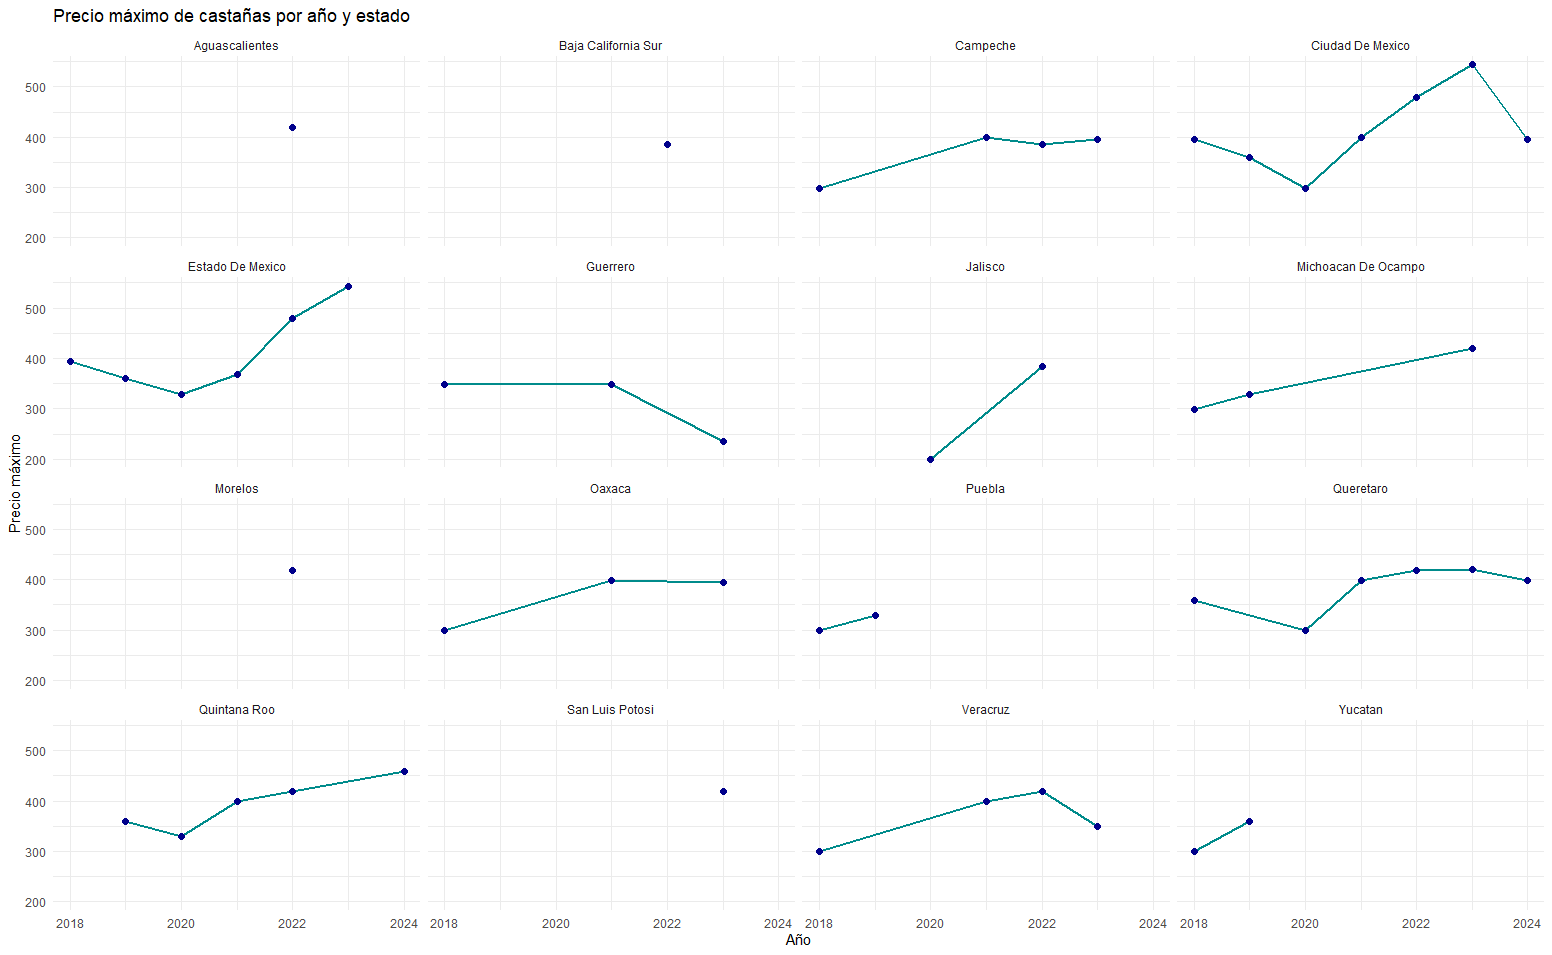